# 6. Grid-to-point CNN-LSTM model with Kriging interpolation

2-step model: Predict points with a grid-to-point CNN-LSTM model with 5 month input and interpolate spatially with Ordinary Kriging

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from pyproj import Transformer
import skgstat as skg
from utils.metrics import *

from tensorflow.keras import metrics
from livelossplot.inputs.keras import PlotLossesCallback
from models.grid_to_point import cnn_lstm

2025-11-14 18:00:14.309324: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 18:00:14.343117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_path = './data/Bangladesh'
outputs_path = f'{root_path}/outputs/'
img_input_path = f"{root_path}/inputs/processed/image_%s.npy"

lag = 5
fill_value = -1

proj_system = 'EPSG:32646'

In [3]:
bgd_shp = gpd.read_file(f'{root_path}/BGD_shp/vb025yv7599.shp')
info_file = pd.read_csv(f'{root_path}/target/well_info.csv')
ndvi_da = xr.open_dataset(f'{root_path}/inputs/NDVI_M_2002_2017_BGD_025.nc4')['NDVI']

In [4]:
cv_setup = np.load(f'{root_path}/cv_setup.npy', allow_pickle=True).item()
train_ids = cv_setup['train_ids']
holdout_ids = cv_setup['holdout_ids']
tr_idxs = cv_setup['tr_idxs']
test_idxs = cv_setup['test_idxs']
seed = cv_setup['seed']

tf.random.set_seed(seed)

In [5]:
filled_ts = pd.read_csv(f"{root_path}/target/filtered_filled_missForest_gws_ts_data_1961_2019.csv", parse_dates=['Date'], index_col='Date')
filled_ts = filled_ts['2002-04-01':'2017-05-31'].dropna(axis=1, how='any')
filled_ts_gwsa = filled_ts - filled_ts['2004-01-01':'2009-12-31'].mean()

df_train = filled_ts_gwsa[train_ids].iloc[(lag-1):]

In [6]:
coords_train = np.array([ info_file[info_file['SegmentID'] == well][['Latitude', 'Longitude']].values[0] for well in train_ids ])
# project the coordinates
transformer = Transformer.from_crs("EPSG:4326", proj_system, always_xy=True)
projected_coords = np.array([
    transformer.transform(lon, lat) for lat, lon in coords_train
])
coords_km = projected_coords / 1000

In [7]:
grid_lon = ndvi_da.lon.values
grid_lat = ndvi_da.lat.values

lon_mesh, lat_mesh = np.meshgrid(grid_lon, grid_lat)

# Project the entire grid
x_mesh, y_mesh = transformer.transform(lon_mesh, lat_mesh)
grid_x = x_mesh / 1000
grid_y = y_mesh / 1000

In [8]:
model = cnn_lstm(lag,24,24, df_train.shape[1], 5) # v3

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 24, 24, 5)]    0         
                                                                 
 time_distributed (TimeDist  (None, 5, 22, 22, 32)     1472      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 11, 11, 32)     0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 9, 9, 64)       18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 4, 4, 64)       0         
 stributed)                                                  

In [10]:
def interpolate(V, x_mesh, y_mesh, time):
    ok = skg.OrdinaryKriging(V, min_points=2, max_points=30, mode='exact')
    field = ok.transform(x_mesh.flatten(), y_mesh.flatten()).reshape(x_mesh.shape)
    return field

for k, (tr_idx, val_test_idx) in enumerate(zip(tr_idxs, test_idxs)):
    model = cnn_lstm(lag,24,24, df_train.shape[1], 5)
    val_idx, tes_idx = val_test_idx[:int(len(val_test_idx)/2)], val_test_idx[int(len(val_test_idx)/2):]

    y_fold_tr = df_train.iloc[tr_idx].to_numpy()
    y_fold_val = df_train.iloc[val_idx].to_numpy()

    ## TODO: check global scaling
    y_min, y_max = np.min(y_fold_tr, axis=0)[np.newaxis, :], np.max(y_fold_tr, axis=0)[np.newaxis, :]
    Y_tr = (y_fold_tr - y_min)/(y_max - y_min)
    Y_val = (y_fold_val - y_min)/(y_max - y_min)

    input_train = np.stack([ np.stack(
        [ np.load(img_input_path % t) for t in range(i - (lag - 1), i + 1)], axis=0) for i in (tr_idx + (lag-1)) ], axis=0
    )
    input_val = np.stack([ np.stack(
        [ np.load(img_input_path % t) for t in range(i - (lag - 1), i + 1)], axis=0) for i in (val_idx + (lag-1)) ], axis=0
    )
    input_test = np.stack([ np.stack(
        [ np.load(img_input_path % t) for t in range(i - (lag - 1), i + 1)], axis=0) for i in (tes_idx + (lag-1)) ], axis=0
    )

    input_train[input_train == -1] = np.nan
    input_val[input_val == -1] = np.nan
    input_test[input_test == -1] = np.nan

    x_min, x_max = np.nanmin(input_train, axis=(0,1,2,3)), np.nanmax(input_train, axis=(0,1,2,3))
    X_tr = (input_train - x_min) / (x_max - x_min)
    X_val = (input_val - x_min) / (x_max - x_min)
    X_test = (input_test - x_min) / (x_max - x_min)
    X_tr[np.isnan(X_tr)] = -1
    X_val[np.isnan(X_val)] = -1
    X_test[np.isnan(X_test)] = -1

    model.compile(optimizer='adam', loss='mean_squared_error', metrics = [ metrics.R2Score() ])
    history = model.fit(X_tr,
          Y_tr,
          batch_size=16,
          epochs=60,
          validation_data=[X_val, Y_val],
          #callbacks=[
              # ModelCheckpoint(filepath=f'g2p_{imput_method}_{target_var}.weights.hdf5',
              #                 save_best_only=True),
          #    PlotLossesCallback()],
          verbose=0)
    
    pred_target = model.predict([
        np.concatenate((X_tr, X_val, X_test), axis=0)],
        batch_size=5)

    rescaled_pred_target = pred_target * (y_max - y_min) + y_min

    np.save(f'{outputs_path}/g2p_CNN_LSTM/g2p_cnn_lstm_point_gwsa_{lag}m_fold_{k}.npy', rescaled_pred_target)
    total_time_len = len(tr_idx) + len(val_test_idx)
    kriged_target = np.zeros((total_time_len, *ndvi_da[0].shape))
    variances = np.zeros((total_time_len, *ndvi_da[0].shape))
    
    variograms = []
    
    for t in range(0, rescaled_pred_target.shape[0]):
        print(f'Interpolating t= {t}')
        variogram = skg.Variogram(coords_km, rescaled_pred_target[t], model='spherical', maxlag='median', use_nugget=True, normalize=False,
                                  fit_method='trf',  # Trust Region Reflective fitting
                                  fit_kwargs={'initial': [0.0013, 0.0025, 200]})
        variograms.append(variogram)
        kriged_target[t] = interpolate(variogram, grid_x, grid_y, df_train.iloc[t].index)

    dates = df_train.index[:(tes_idx[-1]+1)].to_numpy()
    kriged_target_da = xr.DataArray(kriged_target, coords={'time': dates, 'lat': np.round(grid_y[:, 0] * 1000, 2), 'lon': np.round(grid_x[0, :] * 1000, 2)}, dims=['time', 'lat', 'lon'])

    # clip to Bangladesh
    kriged_target_da = kriged_target_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    kriged_target_da = kriged_target_da.rio.write_crs(proj_system, inplace=True)
    kriged_target_da_wgs = kriged_target_da.rio.reproject("EPSG:4326", nodata=np.nan)
    kriged_target_da_wgs = kriged_target_da_wgs.rename({'x': 'lon', 'y': 'lat'})
    kriged_target_da_wgs = kriged_target_da_wgs.rio.clip(bgd_shp.geometry.values, bgd_shp.crs, all_touched=True)
    
    kriged_target_da_wgs.to_dataset(name='gwsa').to_netcdf(f'{outputs_path}/g2p_CNN_LSTM_Kriging/g2p_cnn_lstm_krig_filled_gwsa_{lag}m_fold_{k}.nc4')

7/7 [==============================] - 0s 4ms/step
Interpolating t= 0
Interpolating t= 1
Interpolating t= 2
Interpolating t= 3
Interpolating t= 4
Interpolating t= 5
Interpolating t= 6
Interpolating t= 7
Interpolating t= 8
Interpolating t= 9
Interpolating t= 10
Interpolating t= 11
Interpolating t= 12
Interpolating t= 13
Interpolating t= 14
Interpolating t= 15
Interpolating t= 16
Interpolating t= 17
Interpolating t= 18
Interpolating t= 19
Interpolating t= 20
Interpolating t= 21
Interpolating t= 22
Interpolating t= 23
Interpolating t= 24
Interpolating t= 25
Interpolating t= 26
Interpolating t= 27
Interpolating t= 28
Interpolating t= 29
Interpolating t= 30
Interpolating t= 31
Interpolating t= 32
Interpolating t= 33
10/10 [==============================] - 0s 4ms/step
Interpolating t= 0
Interpolating t= 1
Interpolating t= 2
Interpolating t= 3
Interpolating t= 4
Interpolating t= 5
Interpolating t= 6
Interpolating t= 7
Interpolating t= 8
Interpolating t= 9
Interpolating t= 10
Interpolating t=

<Axes: title={'center': 'time = 2002-08-15, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

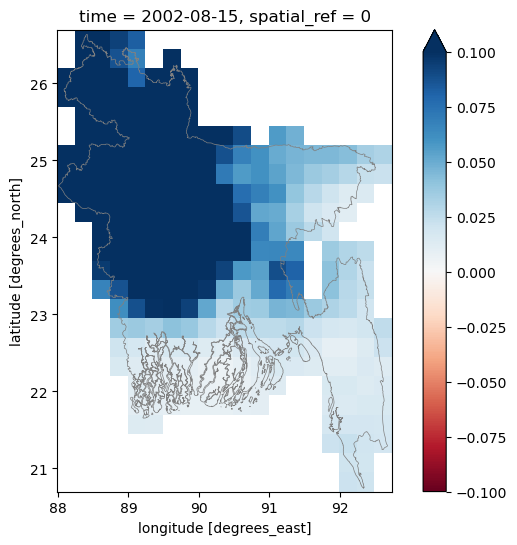

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
kriged_target_da_wgs[0].plot(ax = ax, cmap='RdBu', vmin=-0.1, vmax=0.1)
bgd_shp.boundary.plot(color='gray', linewidth=0.5, ax=ax)